In [38]:
import pandas as pd
import numpy as np
import folium
from sklearn.cluster import DBSCAN
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('NDT_dataset_clean_2.csv', index_col=0)

In [3]:
df['timestamp'] = pd.to_datetime(df['idle_start_time_mdt'], format='mixed')
df['idle_start_hour'] = df['timestamp'].dt.hour

In [16]:
df['lat'] = df['idle_location_y'] / 1e7
df['lon'] = df['idle_location_x'] / 1e7

In [18]:
# Select features
features = df[['lat', 'lon', 'idle_start_hour', 'idle_duration_hr']]

In [20]:
# scale features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

In [40]:
# Prepare coordinates
coords = features[['lat', 'lon']].to_numpy()

In [458]:
dbscan = DBSCAN(eps=0.005, min_samples=5).fit(coords)
features['cluster'] = dbscan.labels_

C:\Users\omoni\AppData\Local\Temp\ipykernel_38220\56947914.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features['cluster'] = dbscan.labels_


In [460]:
features[features['cluster'] == -1]

,lat,lon,idle_start_hour,idle_duration_hr,cluster
0,50.902192,-114.067445,18,0.192500,-1
1,50.859112,-114.010217,19,0.956392,-1
4,51.038268,-114.140078,8,0.426942,-1
5,51.060055,-114.000278,9,0.120836,-1
6,50.989860,-114.044608,9,0.026114,-1
...,...,...,...,...,...
312,51.109488,-114.208493,17,0.088336,-1
313,51.157487,-114.087725,18,1.190833,-1
315,51.150758,-114.109193,9,0.930000,-1
316,51.151242,-114.109317,10,0.155000,-1


In [489]:
cluster_summary = features[features['cluster'] != -1].groupby('cluster').agg({
    'idle_duration_hr': ['sum', 'mean', 'count']
}).reset_index()

cluster_summary.columns = ['cluster', 'total_downtime', 'avg_downtime', 'frequency']

In [491]:
cluster_summary

,cluster,total_downtime,avg_downtime,frequency
0,0,624.768911,8.113882,77
1,1,1.475292,0.092206,16
2,2,1.413058,0.282612,5
3,3,0.596106,0.066234,9
4,4,2.044728,0.255591,8
5,5,3.341119,0.556853,6
6,6,0.079711,0.015942,5


In [493]:
cluster_stats = features.groupby('cluster').agg(
    idle_count=('idle_duration_hr', 'count'),
    avg_idle_duration=('idle_duration_hr', 'mean'),
    total_idle_duration=('idle_duration_hr', 'sum')
).reset_index()

In [495]:
cluster_stats

,cluster,idle_count,avg_idle_duration,total_idle_duration
0,-1,192,0.517134,99.289719
1,0,77,8.113882,624.768911
2,1,16,0.092206,1.475292
3,2,5,0.282612,1.413058
4,3,9,0.066234,0.596106
5,4,8,0.255591,2.044728
6,5,6,0.556853,3.341119
7,6,5,0.015942,0.079711


In [465]:
cluster_stats['score'] = (
    cluster_stats['idle_count'] * cluster_stats['avg_idle_duration']
)

In [468]:
best_cluster = cluster_stats.sort_values('total_idle_duration', ascending=False).iloc[0]
second_best_cluster = cluster_stats.sort_values('total_idle_duration', ascending=False).iloc[1]
third_best_cluster = cluster_stats.sort_values('total_idle_duration', ascending=False).iloc[2]

In [469]:
best_cluster

cluster                  0.000000
idle_count              77.000000
avg_idle_duration        8.113882
total_idle_duration    624.768911
score                  624.768911
Name: 1, dtype: float64

In [470]:
second_best_cluster

cluster                 -1.000000
idle_count             192.000000
avg_idle_duration        0.517134
total_idle_duration     99.289719
score                   99.289719
Name: 0, dtype: float64

In [473]:
third_best_cluster

cluster                5.000000
idle_count             6.000000
avg_idle_duration      0.556853
total_idle_duration    3.341119
score                  3.341119
Name: 6, dtype: float64

In [476]:
best_cluster_id = best_cluster['cluster']
best_coords = features[features['cluster'] == best_cluster_id][['lat', 'lon']].mean()

In [477]:
best_coords

lat     50.944444
lon   -114.127893
dtype: float64

In [480]:
best_times = features[features['cluster'] == best_cluster_id]['idle_start_hour'].value_counts().sort_index()

In [482]:
best_times

idle_start_hour
8      4
9      2
10     2
11     6
12     7
13     6
14    11
15     5
16     1
17     7
18     9
19     7
20     4
21     5
22     1
Name: count, dtype: int64

In [507]:
features.groupby('cluster').agg(
    avg_lat=('lat', 'median'),
    avg_lon=('lon', 'median')).reset_index()

,cluster,avg_lat,avg_lon
0,-1,51.023903,-114.076865
1,0,50.944650,-114.128350
2,1,50.985604,-114.090400
3,2,51.141755,-114.184788
4,3,50.992283,-114.050157
5,4,50.939977,-114.145120
6,5,50.868933,-113.980846
7,6,50.950473,-114.117298


In [485]:
map_center = [features['lat'].mean(), features['lon'].mean()]

m = folium.Map(location=map_center, zoom_start=12)
colors = ['red', 'blue', 'green', 'purple', 'orange', 'darkred', 'cadetblue']

# Plot points for the best cluster
for _, row in features[features['cluster'] == features['cluster']].iterrows():
    folium.CircleMarker(
        location=[row['lat'], row['lon']],
        radius=3,
        color=colors[int(row['cluster']) % len(colors)] if row['cluster'] != -1 else 'gray',
        fill=True,
        fill_opacity=0.5
    ).add_to(m)

m  # Display the map

In [424]:
from sklearn.preprocessing import StandardScaler

# # Assuming your DataFrame is called df and coordinates are in lat/lon format
# df['lat'] = df['idle_location_y'] / 1e7
# df['lon'] = df['idle_location_x'] / 1e7

coords = features[['lat', 'lon']].values
scaler = StandardScaler()
coords_scaled = scaler.fit_transform(coords)

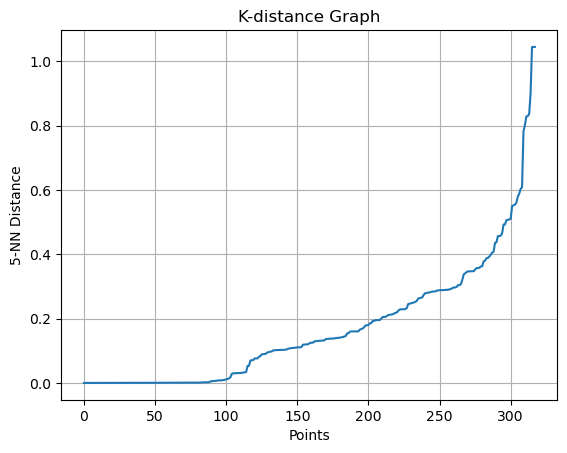

In [425]:
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
import numpy as np

neighbors = NearestNeighbors(n_neighbors=5)
neighbors_fit = neighbors.fit(coords_scaled)
distances, indices = neighbors_fit.kneighbors(coords_scaled)
distances = np.sort(distances[:, 4])  # distance to 5th neighbor

plt.plot(distances)
plt.title('K-distance Graph')
plt.xlabel('Points')
plt.ylabel('5-NN Distance')
plt.grid()
plt.show()
